## Test MLE on a fake Batchelor spectrum.
### Question: What is the influence of variable degrees of freedom?

In [586]:
import sys
sys.path.append('../scripts/')

import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from epsilon_tools import *

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind',font_scale=1.5)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

%matplotlib inline

In [116]:
ds = xr.open_dataset('../data/chi/variable_dof.nc')

In [1253]:
def logbin_data(k_rpm, logbins, chi, kb, p, function):

    if function=='batchelor':
        fun = batchelor
    elif function=='kraichnan':
        fun = kraichnan
    digit = np.digitize(f_cps, logbins)
    ks=[]
    bs=[]
    count=[]
    for i in range(len(logbins)):
        ks.append( np.nanmean( k_rpm[digit==i]) )
        bs.append( np.nanmean( fun( k_rpm[digit==i], chi, kb, p ) ))
        count.append(np.sum(digit==i))

    return np.array(ks), np.array(bs), np.array(count)

In [1514]:
def cost_function(kb, k_rpm, chi, noise, corrdTdz, dof, function):
    '''
    Cost function for MLE to fit spectra
    
    log chi2 rewritten from scipy.chi2._logpdf
    '''
    import bottleneck as bn
    from epsilon_tools import batchelor
    from scipy.special import xlogy, gammaln
    import numpy as np
    import math

    if function.lower() == 'batchelor':
        theory = batchelor(k_rpm, chi, kb, p)
    elif function.lower() == 'kraichnan':
        theory = kraichnan(k_rpm, chi, kb, p)
    elif function.lower() == 'power':
        theory = kb[0]*k_rpm**(-kb[1])
    else:
        raise ValueError('Function not known!')

    a =  dof / (theory + noise)
    b = corrdTdz * a
    
    summe = -np.nansum(np.log(a)) - np.nansum(xlogy(dof/2-1, b)) +\
            np.nansum(b/2) + np.nansum(gammaln(dof/2.) + (math.log(2)*dof)/2)
    return summe

In [1515]:
from scipy.stats import chi2

In [1516]:
def noise_sp(f_cps):
    ''' 
    Empirical noise spectrum
    '''
    return 1e-11 * (1 + (f_cps / 15)**3)**2

### Recipe:
1. create continuous batchelor spectrum choosing k$_b$ and $\chi$
2. bin the spectrum in frequency space
3. apply MLE to find k$_b$
    a) with variable degrees of freedom
    b) with fixed degrees of freedom
4. compare estimated k$_b$ to true k$_b$

In [1540]:
def trial_eps_estimation(f_cps, kbs, variable_dof, function):
    p = Parameters()
    chi=1e-8
    w = 0.1

    logbins = np.logspace(-1,1.7,20)
    #logbins = ds.f_cps.values

    
    estimated_kb = []
    for kb in kbs:
        k_rpm = f_cps* 2 * np.pi/w
        k_rpm, b_rpm, count = logbin_data(k_rpm, logbins, chi, kb, p, function)

        if variable_dof:
            #dof = np.round( ds.isel(time=0).dof.values )
            dof = 2*count
        else:
            dof = 100
        
        noise = 1e-8*np.ones_like(k_rpm) #k_rpm**2*noise_sp(k_rpm*w/(2*np.pi))*w/ (2 * np.pi)

        args = (k_rpm, chi, noise, b_rpm, dof, function)
        options = {'maxiter':1000,'xatol':1e-10,'fatol':1e-10}
        m = minimize(cost_function, x0=350, args=args, method='Nelder-Mead', options=options)
        if m.success:
            estimated_kb.append(m.x)
        else:
#             print(f'{m.message}')
            estimated_kb.append(np.nan)
    return np.array( estimated_kb ).flatten().astype(float)

In [1541]:
k_rpm**2*noise_sp(k_rpm*w/(2*np.pi))*w/ (2 * np.pi)

array([2.26307840e-12, 1.41442665e-11, 2.39038676e-11, 4.08772503e-11,
       8.14730661e-11, 1.63520256e-10, 3.12511152e-10, 5.88751745e-10,
       1.12194649e-09, 2.16545560e-09, 4.17741220e-09, 8.08638837e-09,
       1.59839673e-08, 3.37267838e-08, 8.29753771e-08, 2.73201619e-07,
       1.37372186e-06, 1.05798288e-05, 1.08623231e-04, 1.28570200e-03])

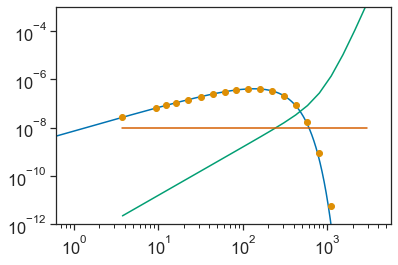

In [1543]:
k_rpm = f_cps* 2 * np.pi/w
plt.loglog(k_rpm, batchelor(k_rpm, chi, kb, p), '-')
k_rpm, b_rpm, count = logbin_data(k_rpm, logbins, chi, kb, p, 'batchelor')
plt.loglog(k_rpm, b_rpm, 'o')
plt.ylim(1e-12,1e-3)
plt.loglog(k_rpm,k_rpm**2*noise_sp(k_rpm*w/(2*np.pi))*w/ (2 * np.pi))
plt.loglog(k_rpm,1e-8*np.ones_like(k_rpm))

In [1544]:
kbs = np.linspace(250,500,600)
f_cps = np.linspace(0,60,4000)

variable = trial_eps_estimation(f_cps, kbs, True, 'kraichnan')
fixed = trial_eps_estimation(f_cps, kbs, False, 'kraichnan')
variableb = trial_eps_estimation(f_cps, kbs, True, 'batchelor')
fixedb = trial_eps_estimation(f_cps, kbs, False, 'batchelor')

In [1545]:
def epsilon(kb):
    return kb**4 * p.nu * p.D**2

def eps2kb(eps):
    return (eps/(p.nu * p.D**2))**(1/4)

def make_arrow_annotation(ax, datatuple , offsettuple, **kwargs):
    ax.annotate(r'initial guess for x$_0$',
            xy=datatuple, xycoords='data',
            xytext=offsettuple, textcoords='offset points',
            arrowprops=dict(arrowstyle='->',color='k'),
            horizontalalignment='right', verticalalignment='bottom', fontsize=15, clip_on=True, **kwargs)

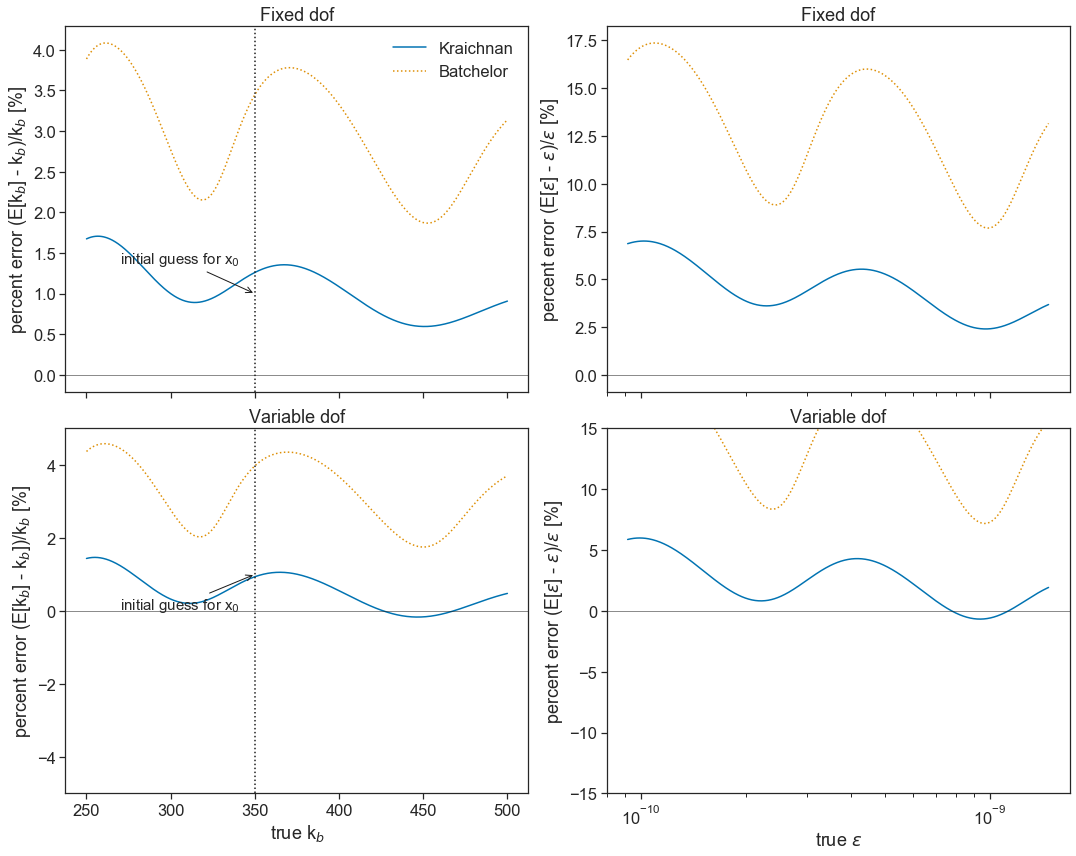

In [1546]:
f, ax = plt.subplots(2,2, figsize=(15,12), sharex='col')

ax = ax.flatten()
ax[0].plot(kbs, 100*(fixed-kbs)/kbs, label='Kraichnan')
ax[0].plot(kbs, 100*(fixedb-kbs)/kbs, ls='dotted', label='Batchelor')
ax[0].set_ylabel(r'percent error (E[k$_b$] - k$_b$)/k$_b$ [%]')
# ax[0].set_xlabel(r'true k$_b$');
ax[0].set_title('Fixed dof')
ax[0].axvline(350,color='k', ls='dotted')
ax[0].axhline(0,color='k', lw=0.5)
make_arrow_annotation(ax[0], (350,1), (-15,25))
ax[0].legend()

ax[1].plot( epsilon(kbs), 100*(epsilon( fixed)-epsilon(kbs))/epsilon(kbs) )
ax[1].plot( epsilon(kbs), 100*(epsilon( fixedb)-epsilon(kbs))/epsilon(kbs), ls='dotted')
ax[1].set_ylabel(r'percent error (E[$\epsilon$] - $\epsilon$)/$\epsilon$ [%]')
# ax[1].set_xlabel(r'true $\epsilon$');
ax[1].set_xscale('log')
ax[1].set_title('Fixed dof')
ax[1].axhline(0,color='k', lw=0.5)

ax[2].plot(kbs, 100*(variable - kbs)/kbs )
ax[2].plot(kbs, 100*(variableb - kbs)/kbs , ls='dotted')
ax[2].set_ylabel(r'percent error (E[k$_b$] - k$_b$])/k$_b$ [%]')
ax[2].set_xlabel(r'true k$_b$');
ax[2].set_ylim(-5,5)
ax[2].set_title('Variable dof')
ax[2].axvline(350,color='k', ls='dotted')
ax[2].axhline(0,color='k', lw=0.5)
make_arrow_annotation(ax[2], (350,1), (-15,-40))

ax[3].plot( epsilon(kbs), 100*(epsilon( variable)-epsilon(kbs))/epsilon(kbs) )
ax[3].plot( epsilon(kbs), 100*(epsilon( variableb)-epsilon(kbs))/epsilon(kbs) , ls='dotted')
ax[3].set_ylabel(r'percent error (E[$\epsilon$] - $\epsilon$)/$\epsilon$ [%]')
ax[3].set_xlabel(r'true $\epsilon$');
ax[3].set_xscale('log')
ax[3].set_ylim(-15,15)
ax[3].set_title('Variable dof')
ax[3].axhline(0,color='k', lw=0.5)

plt.subplots_adjust()
plt.tight_layout()
plt.savefig('../figures/fake_batchelor.pdf')
plt.show()

### Plot Batchelor and Kraichnan spectrum as a function of $\chi$ amd $k_b$

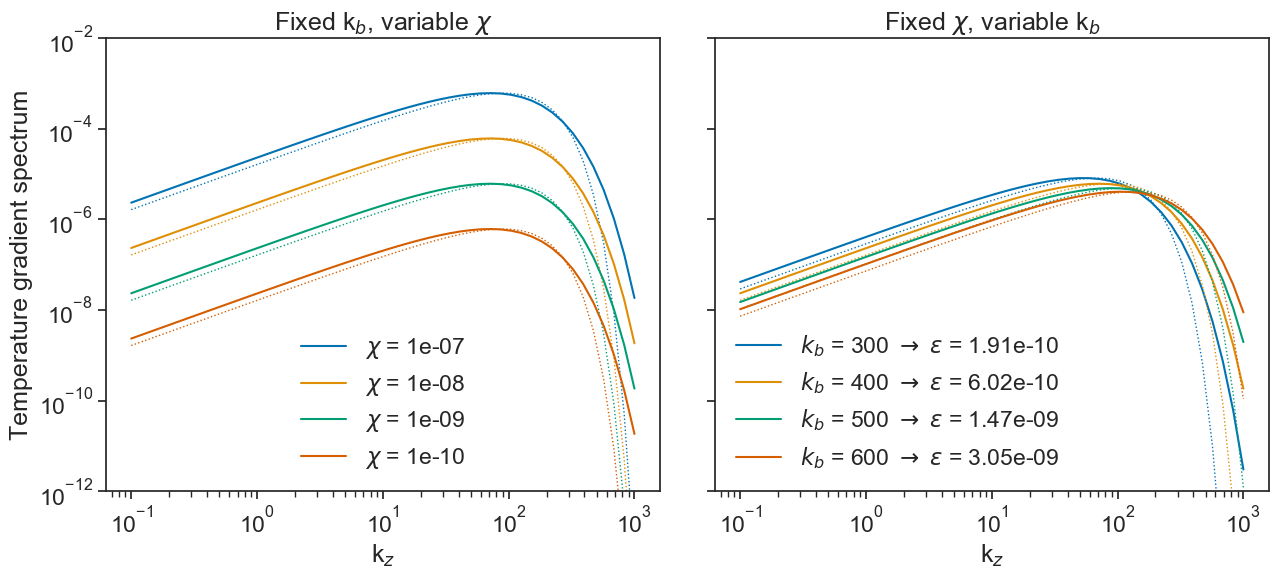

In [1503]:
f,ax = plt.subplots(1,2, figsize=(15,6), sharey=True, dpi=100)

colors = sns.color_palette(n_colors=4)

k_rpm = np.logspace(-1,3)
fixed_kb = 400
variable_chi = [1e-7,1e-8,1e-9,1e-10]

for i,chi in enumerate( variable_chi ):
    ax[0].plot(k_rpm, kraichnan(k_rpm,chi, fixed_kb, p), label=rf'$\chi$ = {chi}', color=colors[i])
    ax[0].plot(k_rpm, batchelor(k_rpm,chi, fixed_kb, p), label=f'_{chi}', lw=1, ls='dotted', color=colors[i])
    
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Fixed k$_b$, variable $\chi$')
ax[0].set_ylabel('Temperature gradient spectrum')
ax[0].set_xlabel('k$_z$')
ax[0].set_ylim(1e-12,1e-2)
ax[0].legend()

variable_kb = [300, 400, 500, 600]
fixed_chi = 1e-9
for i,kb in enumerate(variable_kb):
    eps = kb**4*p.D**2*p.nu
    ax[1].plot(k_rpm, kraichnan(k_rpm,fixed_chi, kb, p), label=rf'$k_b$ = {kb} $\rightarrow$ $\epsilon$ = {eps:1.2e}', color=colors[i])
    ax[1].plot(k_rpm, batchelor(k_rpm,fixed_chi, kb, p), label=f'_{kb}', lw=1, ls='dotted', color=colors[i])

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Fixed $\chi$, variable k$_b$')
ax[1].set_xlabel('k$_z$')
ax[1].legend()

plt.subplots_adjust(wspace=0.1)
plt.savefig('../figures/kraichnan_model.pdf')
plt.show()

In [1009]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [1504]:
@interact
def scatter(chi=list(variable_chi),kb=list(variable_kb)):
    plt.plot(k_rpm,batchelor(k_rpm,chi, kb, p))
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-12,1e-2)

interactive(children=(Dropdown(description='chi', options=(1e-07, 1e-08, 1e-09, 1e-10), value=1e-07), Dropdown…